In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import os, sys
import copy
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import colorbar, colors, gridspec
from metpy import plots as metpy_plots
from matplotlib.colors import ListedColormap, BoundaryNorm


HOME = Path(os.getcwd()).parents[0]

sys.path.insert(1, str(HOME))

from dsrnngan.plots import plot_precip, plot_contourf
from dsrnngan.data import denormalise, DEFAULT_LATITUDE_RANGE, DEFAULT_LONGITUDE_RANGE
from dsrnngan import data
from dsrnngan.noise import NoiseGenerator
from dsrnngan.rapsd import plot_spectrum1d, rapsd
from dsrnngan.thresholded_ranks import findthresh

In [34]:
# model_number = 230400
# model_number = 160000
# model_number = 153600
model_number = 288000

model_type = 'cropped_4000'

log_folders = {'basic': '/user/work/uz22147/logs/cgan/d9b8e8059631e76f/n1000_201806-201905_e50',
               'cropped': '/user/work/uz22147/logs/cgan/ff62fde11969a16f/n2000_201806-201905_e20',
               'cropped_4000': '/user/work/uz22147/logs/cgan/ff62fde11969a16f/n4000_201806-201905_e10'}

log_folder = log_folders[model_type]
with open(os.path.join(log_folder, f'arrays-{model_number}.pkl'), 'rb') as ifh:
    arrays = pickle.load(ifh)
    
truth_array = arrays['truth']
samples_gen_array = arrays['samples_gen']
fcst_array = arrays['fcst_array']
persisted_fcst_array = arrays['persisted_fcst']
ensmean_array = np.mean(arrays['samples_gen'], axis=-1)
dates = [d[0] for d in arrays['dates']]
hours = [h[0] for h in arrays['hours']]

assert len(set(list(zip(dates, hours)))) == fcst_array.shape[0], "Degenerate date/hour combinations"
(n_samples, width, height, ensemble_size) = samples_gen_array.shape


In [35]:
from dsrnngan.utils import load_yaml_file
# Get lat/lon range from log folder
base_folder = '/'.join(log_folder.split('/')[:-1])
config = load_yaml_file(os.path.join(base_folder, 'setup_params.yaml'))

# Locations
min_latitude = config['DATA']['min_latitude']
max_latitude = config['DATA']['max_latitude']
latitude_step_size = config['DATA']['latitude_step_size']
min_longitude = config['DATA']['min_longitude']
max_longitude = config['DATA']['max_longitude']
longitude_step_size = config['DATA']['longitude_step_size']
latitude_range=np.arange(min_latitude, max_latitude, latitude_step_size)
longitude_range=np.arange(min_longitude, max_longitude, longitude_step_size)

lat_range_list = [np.round(item, 2) for item in sorted(latitude_range)]
lon_range_list = [np.round(item, 2) for item in sorted(longitude_range)]

special_areas = {'lake_victoria': {'lat_range': [-3.05,1.05], 'lon_range': [31.05, 35.05]},
                 'nairobi': {'lat_range': [-1.55,-1.05], 'lon_range': [36.55, 37.05]},
                 'mombasa (coastal)': {'lat_range': [-4.15,-3.95], 'lon_range': [39.55, 39.85]},
                #  'addis ababa': {'lat_range': [8.8, 9.1], 'lon_range': [38.5, 38.9]},
                 'bale_mountains': {'lat_range': [6.65, 7.05], 'lon_range': [39.35, 40.25]},
                #  'Butembo / virunga (DRC)': {'lat_range': [-15.05, 0.55], 'lon_range': [29.05, 29.85]},
                 'Kampala': {'lat_range': [.05, 0.65], 'lon_range': [32.15, 32.95]},
                 'Nzoia basin': {'lat_range': [-0.35, 1.55], 'lon_range': [34.55, 36.55]}}

for k, v in special_areas.items():
    special_areas[k]['lat_index_range'] = [lat_range_list.index(v['lat_range'][0]), lat_range_list.index(v['lat_range'][1])]
    special_areas[k]['lon_index_range'] = [lon_range_list.index(v['lon_range'][0]), lon_range_list.index(v['lon_range'][1])]

# Quantiles
step_size = 0.001
range_dict = {0: {'start': 0.1, 'stop': 1, 'interval': 0.1, 'marker': '+', 'marker_size': 64},
              1: {'start': 1, 'stop': 10, 'interval': 1, 'marker': '+', 'marker_size': 512},
              2: {'start': 10, 'stop': 80, 'interval':10, 'marker': '+', 'marker_size': 1024},
              3: {'start': 80, 'stop': 99.1, 'interval': 1, 'marker': '+', 'marker_size': 512},
              4: {'start': 99.1, 'stop': 99.91, 'interval': 0.1, 'marker': '+', 'marker_size': 256},
              5: {'start': 99.9, 'stop': 99.99, 'interval': 0.01, 'marker': '+', 'marker_size': 64 },
              6: {'start': 99.99, 'stop': 99.999, 'interval': 0.001, 'marker': '+', 'marker_size': 20},
              7: {'start': 99.999, 'stop': 99.9999, 'interval': 0.0001, 'marker': '+', 'marker_size': 20}}
                  
percentiles_list= [np.arange(item['start'], item['stop'], item['interval']) for item in range_dict.values()]
percentiles=np.concatenate(percentiles_list)
quantile_locs = [np.round(item / 100.0, 6) for item in percentiles]

## Quantile mapping

In [36]:
from dsrnngan.data import denormalise
from glob import glob

fps = glob('/user/work/uz22147/quantile_training_data/*_744.pkl')

imerg_train_data = []
ifs_train_data = []
training_dates = []
training_hours = []

for fp in fps:
    with open(fp, 'rb') as ifh:
        training_data = pickle.load(ifh)
        
    imerg_train_data.append(denormalise(training_data['obs']))
    ifs_train_data.append(denormalise(training_data['fcst_array']))

    training_dates += [item[0] for item in training_data['dates']]
    training_hours += [item[0] for item in training_data['hours']]

imerg_train_data = np.concatenate(imerg_train_data, axis=0)
ifs_train_data = np.concatenate(ifs_train_data, axis=0)


In [37]:
# Get  distribution of number of rainy pixels per square
threshold = 0.1
rainy_pixel_fraction = np.mean((imerg_train_data > threshold).astype(np.int0), axis=(1,2))

[q0pt25, q0pt5, q0pt75] = np.quantile(rainy_pixel_fraction, [0.25, 0.5, 0.75])

In [38]:
from dsrnngan.benchmarks import get_quantile_areas, get_quantiles_by_area, get_quantile_mapped_forecast

month_ranges = [[1,2], [3,4,5], [6,7,8,9], [10,11,12]]
quantile_threshold = 0.999

# identify best threshold and train on all the data
quantile_areas = get_quantile_areas(list(training_dates), month_ranges, latitude_range, longitude_range, hours=training_hours, num_lat_lon_chunks=1)
quantiles_by_area = get_quantiles_by_area(quantile_areas, fcst_data=ifs_train_data, obs_data=imerg_train_data, 
                                          quantile_locs=quantile_locs)

fcst_corrected = get_quantile_mapped_forecast(fcst=fcst_array, dates=dates, 
                                              hours=hours, month_ranges=month_ranges, 
                                              quantile_areas=quantile_areas, 
                                              quantiles_by_area=quantiles_by_area)
                                            #   quantile_threshold=0.99999)

## Long term IMERG observations


In [8]:
import xarray as xr

all_imerg_data = []
all_ifs_data = []

for year in tqdm(range(2003, 2018)):
    for month in range(1,13):

        imerg_ds = xr.open_dataarray(f'/user/home/uz22147/repos/rainfall_data/daily_imerg_rainfall_{month}_{year}.nc')

        imerg_data = imerg_ds.sel(lat=latitude_range, method='nearest').sel(lon=longitude_range, method='nearest').values

        for t in range(imerg_data.shape[0]):
            
            snapshot = imerg_data[t, :, :]
            
            all_imerg_data.append(snapshot)
            
all_imerg_data = np.stack(all_imerg_data, axis = 0)

daily_historical_avg = np.mean(all_imerg_data, axis=0)
daily_historical_std = np.std(all_imerg_data, axis=0)

hourly_historical_avg = daily_historical_avg / 24
hourly_historical_std = daily_historical_std / 24

100%|██████████| 15/15 [00:24<00:00,  1.64s/it]


In [ ]:
# Summary statistics
array_dict = {'IFS': fcst_array, 'IFS qmap': fcst_corrected ,'iMERG': truth_array, 'cGAN': samples_gen_array}
for k, v in array_dict.items():
    
    print('*'*10)
    print(k)
    print('Mean = ', v.mean())
    print('Max = ', v.max())
    print('Min = ', v.min())

In [ ]:
# Find dry and rainy days in sampled dataset
means = [(n, truth_array[n,:,:].mean()) for n in range(n_samples)]
sorted_means = sorted(means, key=lambda x: x[1])

n_extreme_days = 10
wet_day_indexes = [item[0] for item in sorted_means[-10:]]
dry_day_indexes = [item[0] for item in sorted_means[:10]]

In [ ]:
def clip_outliers(data, lower_pc=2.5, upper_pc=97.5):
    
    data_clipped = copy.deepcopy(data)
    data_clipped[data_clipped<np.percentile(data_clipped, lower_pc)] = np.percentile(data_clipped, lower_pc)  #using percentiles rather than indexing a sorted list of the array values allows this to work even when data is a small array. (I've not checked if this works for masked data.)
    data_clipped[data_clipped>np.percentile(data_clipped, upper_pc)] = np.percentile(data_clipped, upper_pc)

    return data_clipped


In [ ]:
from dsrnngan.data import DEFAULT_LATITUDE_RANGE, DEFAULT_LONGITUDE_RANGE
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm

tp_index = data.all_ifs_fields.index('tp')

# plot configurations
levels = [0, 0.1, 1, 2.5, 5, 10, 15, 20, 30, 40, 50, 70, 100, 150] # in units of log10
precip_cmap = ListedColormap(metpy_plots.ctables.colortables["precipitation"][:len(levels)-1], 'precipitation')
precip_norm = BoundaryNorm(levels, precip_cmap.N)
plt.rcParams.update({'font.size': 11})
spacing = 10
units = "Rain rate [mm h$^{-1}$]"
precip_levels=np.arange(0, 1.5, 0.15)

indexes = wet_day_indexes[:10] 
# + dry_day_indexes[:2]
num_cols = 6
num_samples = len(indexes)
num_rows = num_samples
# , figsize = (num_rows*4, num_cols*4)),
# gs = gridspec.GridSpec(spacing*num_rows+1, spacing*num_cols, wspace=0.5, hspace=2)
rows = [[f'cgan_sample_{n}', f'cgan_mean_{n}', f'imerg_{n}', f'ifs_{n}', f'ifs_qmap_{n}', 'cbar'] for n in range(num_rows)]

fig = plt.figure(constrained_layout=True, figsize=(2.5*num_cols, 3*num_rows))
gs = gridspec.GridSpec(num_rows + 1, num_cols, figure=fig, 
                       width_ratios=[1]*(num_cols - 1) + [0.05],
                       height_ratios=[1]*(num_rows) + [0.05],
                       wspace=0.005)                      
for n in tqdm(range(len(indexes))):

    ix = indexes[n]
    img_gens = samples_gen_array[ix, :,:,:]
    truth = truth_array[ix,:,:]
    fcst = fcst_array[ix,:,:]
    fcst_corr = fcst_corrected[ix, :, :]
    date = dates[ix]
    hour = hours[ix]
    avg_img_gens = img_gens.mean(axis=-1)
    date_str = date.strftime('%d-%m-%Y') + f' {hour:02d}:00:00'
    
    # cGAN
    data_lookup = {'cgan_sample': {'data': img_gens[:,:,0], 'title': 'cGAN sample'},
                   'cgan_mean': {'data': avg_img_gens, 'title': f'cGAN sample average'},
                   'imerg' : {'title': f"IMERG: {date_str}", 'data': truth},
                   'ifs': {'data': fcst, 'title': 'IFS'},
                   'ifs_qmap': {'data': fcst_corr, 'title': 'IFS qmap'}
                   }
    for col, (k, val) in enumerate(data_lookup.items()):
   
        ax = fig.add_subplot(gs[n, col], projection = ccrs.PlateCarree())
        # im = plot_precip(np_array=np.log(val['data']), ax=ax)
        ax.coastlines(resolution='10m', color='black', linewidth=0.4)
        
        clipped_data = clip_outliers(val['data'], lower_pc=0.1, upper_pc=99.9)
        im = ax.imshow(val['data'],
                interpolation='nearest',
                norm=precip_norm,
                cmap=precip_cmap,
                origin='lower',
                extent=[min(DEFAULT_LONGITUDE_RANGE), max(DEFAULT_LONGITUDE_RANGE), 
                  min(DEFAULT_LATITUDE_RANGE), max(DEFAULT_LATITUDE_RANGE)],
                transform=ccrs.PlateCarree(),
                alpha=0.8)
        ax.add_feature(cfeature.BORDERS)
        ax.set_title(val['title'])
        
# precip_cmap = ListedColormap(metpy_plots.ctables.colortables["precipitation"][:len(precip_levels)-1], 'precipitation')
# precip_norm = BoundaryNorm(precip_levels, precip_cmap.N)
cbar_ax = fig.add_subplot(gs[-1, :])
# cb = mpl.colorbar.Colorbar(axd['cbar'], cmap=precip_cmap, norm=precip_norm)
# cbar_ax = fig.add_axes([0.95, 0.0, 0.02, 0.95])
cb = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', shrink = 0.2, aspect=10,
                  )

# cb.ax.set_yticks(precip_levels)
# cb.ax.set_yticklabels(precip_levels)
# cb.ax.tick_params(axis='both', which='major')
cb.ax.set_xlabel("Precipitation (mm / hr)", loc='center')


plt.savefig(f'cGAN_samples_IFS_{model_type}_{model_number}.pdf', format='pdf')

# Event-based metrics

In [10]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
threshold = 1/24.0 # mm/hr

y_true = (truth_array > threshold).astype(np.int0).flatten()

y_dict = {
          'ifs': (fcst_array > threshold).astype(np.int0).flatten(),
          'cgan' : (samples_gen_array[:,:,:,0]> threshold).astype(np.int0).flatten(),
          'ifs_qmap': (fcst_corrected > threshold).astype(np.int0).flatten(),
          'persistence': (persisted_fcst_array > threshold).astype(np.int0).flatten()}

confusion_matrices = {}
for k, v in tqdm(y_dict.items()):
    confusion_matrices[k] = confusion_matrix(y_true, v)
    
    with open(f'cgan_metrics/confusion_matrices_thr{int(threshold*24)}.pkl', 'wb+') as ofh:
        pickle.dump(confusion_matrices, ofh)

100%|██████████| 4/4 [05:53<00:00, 88.40s/it]


In [4]:
def recall(c):
    return c[1][1] / (c[1][0] + c[1][1])

def precision(c):
    return c[1][1] / (c[0][1] + c[1][1])

def f1(c):
    r = recall(c)
    p = precision(c)
    
    f1 = 2*p*r / (p+r)
    
    return f1

def hit_rate(c):
    return recall(c)

def false_alarm_rate(c):
    return c[0][1] / (c[0][0] + c[0][1])

def pierce_skill_score(c):
    return hit_rate(c) - false_alarm_rate(c)

def critical_success_index(c):
    
    return c[1][1] / (c[1][1] + c[0][1] + c[1][0])

In [22]:
# Load confucion  matrices and look at results
import pandas as pd


# for thr in [1, 5, 20, 30, 50]:
thr = 50
rows = []
with open(f'/user/home/uz22147/repos/downscaling-cgan/plots/confusion_matrices.pkl', 'rb') as ifh:
    cm_data = pickle.load(ifh)
    


In [27]:
print(f"Threshold = {cmat['threshold']}")
rows = []
for k in ['ifs', 'cgan', 'ifs_qmap']:

    rows.append({'forecast': k ,'csi': critical_success_index(cmat[k]), 'pierce_skill_score': pierce_skill_score(cmat[k]), 'hit_rate': hit_rate(cmat[k])})
        
pd.DataFrame(rows)

Threshold = 22.4846993055437


,forecast,csi,pierce_skill_score,hit_rate
0,ifs,0.010582,0.011738,0.011749
1,cgan,0.005999,0.010895,0.010978
2,ifs_qmap,0.012393,0.021426,0.021500


In [ ]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_true, np.mean((samples_gen_array[:,:,:,:]> threshold).astype(np.int0), axis=-1).flatten())

In [ ]:
with open(f'../plots/confusion_matrices_thr{threshold}.pkl', 'wb+') as ofh:
    pickle.dump(confusion_matrices, ofh)

# Reliability diagnostics

### Spread error relationship

In [ ]:
ens_rmse = np.sqrt(np.mean(np.power(ensmean_array - truth_array, 2), axis=0))
spread = np.mean(np.std(samples_gen_array, axis=-1), axis=0)

ens_rmse_grid = np.abs(ensmean_array - truth_array)
spread_grid = np.std(samples_gen_array, axis=-1)

In [ ]:
from scipy.stats import pearsonr

fig, ax = plt.subplots(1,1)

ax.scatter( spread_grid.flatten(), ens_rmse_grid.flatten())
ax.set_xlabel('Spread')
ax.set_ylabel('RMSE')

print(pearsonr(ens_rmse_grid.flatten(), spread_grid.flatten()).statistic)

## Rank histogram

In [ ]:
rng = np.random.default_rng()
noise_factor = 1e-6
n_samples = 100

temp_truth = np.repeat(truth_array[:n_samples, :, : ,None].copy(), samples_gen_array.shape[-1], axis=-1)
temp_samples = samples_gen_array[:n_samples, :, :, :].copy()

temp_truth += rng.random(size=temp_truth.shape, dtype=np.float32)*noise_factor
temp_samples += rng.random(size=temp_samples.shape, dtype=np.float32)*noise_factor

ranks = np.sum(temp_truth > temp_samples, axis=-1)

n_bins = samples_gen_array.shape[-1]

fig, ax = plt.subplots(1,1)
(h, _) = np.histogram(ranks.flatten() / ranks.size, bins=n_bins)
h = h / h.sum()
ax.plot(h)
ax.hlines(1/n_bins, 0, n_bins, linestyles='dashed', colors=['r'])
# ax.set_xticks(np.arange(0, n_bins + 1, 10))
# ax.set_xticklabels(np.round(np.arange(0, 1.2, 0.2), 1))
ax.set_ylim([0, max(h)+0.01])
ax.set_title('Rank histogram ')
# plt.savefig(f'cgan_metrics/rank_hist_{model_number}.png')

# RAPSD

In [8]:
from dsrnngan.rapsd import rapsd

rapsd_truth = []
rapsd_pred = []
rapsd_fcst = []
rapsd_fcst_corrected = []  
rapsd_fcst_persisted = []

for n in tqdm(range(n_samples)):
        fft_freq_pred = rapsd(truth_array[n,:,:], fft_method=np.fft)
        rapsd_truth.append(fft_freq_pred)
        
        fft_freq_pred = rapsd(samples_gen_array[n,:,:,0], fft_method=np.fft)
        rapsd_pred.append(fft_freq_pred)

        fft_freq_fcst = rapsd(fcst_array[n, :, :], fft_method=np.fft)
        rapsd_fcst.append(fft_freq_fcst)
        
        fft_freq_fcst_corrected = rapsd(fcst_corrected[n, :, :], fft_method=np.fft)
        rapsd_fcst_corrected.append(fft_freq_fcst_corrected)
        
        fft_freq_fcst_persisted = rapsd(persisted_fcst_array[n, :, :], fft_method=np.fft)
        rapsd_fcst_persisted.append(fft_freq_fcst_persisted)

rapsd_truth = np.mean(np.stack(rapsd_truth, axis=-1), axis=-1)
rapsd_pred = np.mean(np.stack(rapsd_pred, axis=-1), axis=-1)
rapsd_fcst = np.mean(np.stack(rapsd_fcst, axis=-1), axis=-1)
rapsd_fcst_corrected = np.mean(np.stack(rapsd_fcst_corrected, axis=-1), axis=-1)
rapsd_fcst_persisted = np.mean(np.stack(rapsd_fcst_persisted, axis=-1), axis=-1)

100%|██████████| 4000/4000 [03:20<00:00, 19.99it/s]


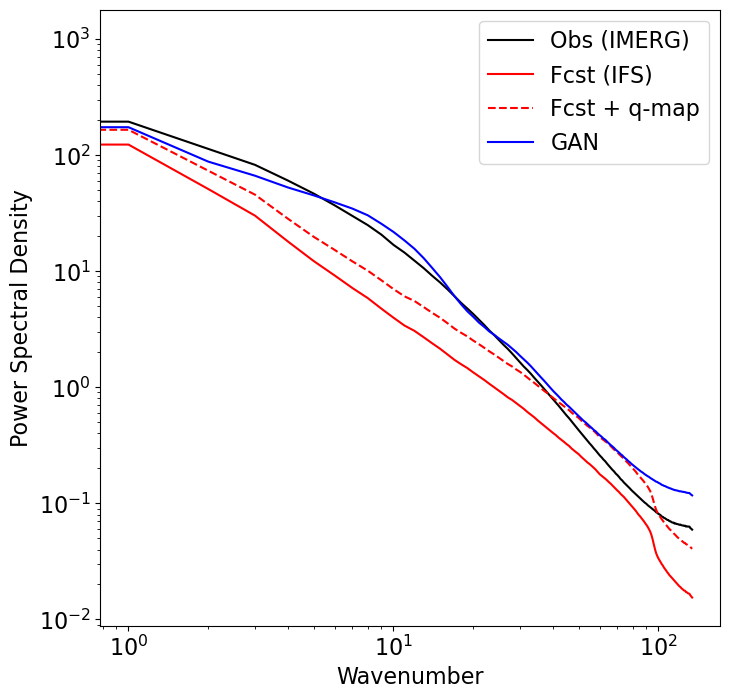

In [14]:
fig, ax = plt.subplots(1,1, figsize=(8,8))

ax.plot(rapsd_truth, label='Obs (IMERG)', color='k')
ax.plot(rapsd_fcst, 'r', label='Fcst (IFS)')
ax.plot(rapsd_fcst_corrected, 'r--', label='Fcst + q-map')
ax.plot(rapsd_pred, 'b', label='GAN') # Single member of ensemble
# ax.plot(rapsd_fcst_persisted, 'k--', label='Persisted')
plt.xscale('log')
plt.yscale('log')
ax.set_ylabel('Power Spectral Density')
ax.set_xlabel('Wavenumber')
ax.legend()
plt.rcParams.update({'font.size': 16})
plt.savefig(f'cgan_metrics/rapsd_{model_type}_{model_number}.pdf', format='pdf')

## Quantiles

100%|██████████| 8/8 [03:44<00:00, 28.07s/it]


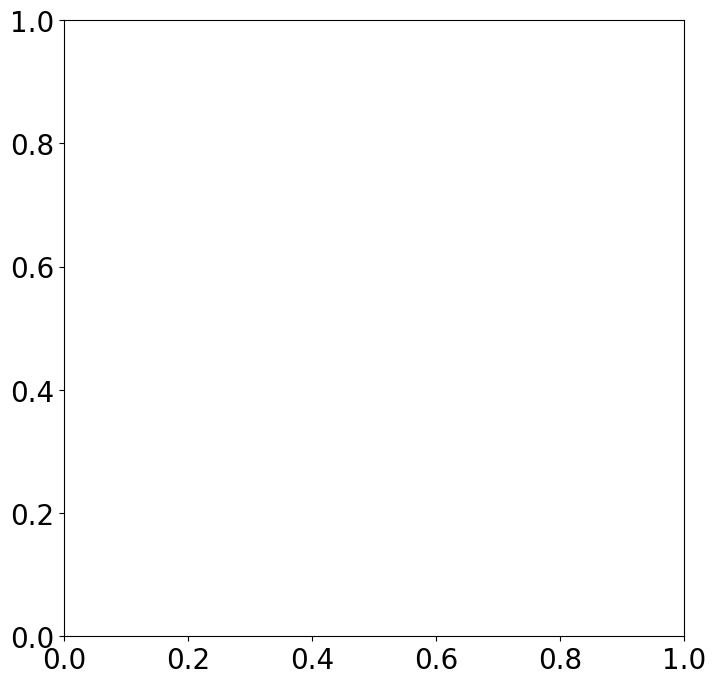

In [22]:
import itertools


marker_handles = None
truth_quantiles = {}
sample_quantiles = {}
fcst_quantiles = {}
fcst_corrected_quantiles = {}
persisted_fcst_quantiles = {}

for k, v in tqdm(range_dict.items()):
    
    quantile_boundaries = np.arange(v['start'], v['stop'], v['interval']) / 100
    
    truth_quantiles[k] = np.quantile(truth_array, quantile_boundaries)
    sample_quantiles[k] = np.quantile(samples_gen_array[:,:,:,0], quantile_boundaries)
    fcst_quantiles[k] = np.quantile(fcst_array, quantile_boundaries)
    fcst_corrected_quantiles[k] = np.quantile(fcst_corrected, quantile_boundaries)
    persisted_fcst_quantiles[k] = np.quantile(persisted_fcst_array, quantile_boundaries)

    max_fcst_val = max(max(sample_quantiles), max(fcst_quantiles))
    max_truth_val = max(truth_quantiles)


100%|██████████| 8/8 [00:00<00:00, 264.91it/s]


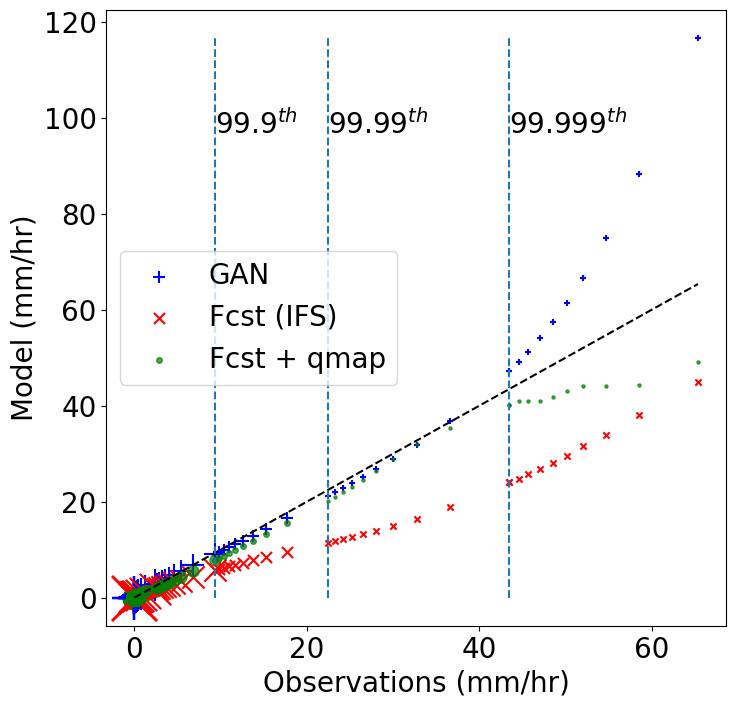

In [27]:

fig, ax = plt.subplots(1,1, figsize=(8,8))

# Quantiles for annotating plot

(q_99pt9, q_99pt99, q_99pt999) = np.quantile(truth_array, [0.999, 0.9999, 0.99999])

for k, v in tqdm(range_dict.items()):    
    size=v['marker_size']
    cmap = plt.colormaps["plasma"]
    marker = v['marker']
    
    max_fcst_val = max(max(sample_quantiles[k]), max(fcst_quantiles[k]))
    max_truth_val = max(truth_quantiles[k])

    s1 = ax.scatter(truth_quantiles[k], sample_quantiles[k], c='blue', marker='+', label='GAN', s=size, cmap=cmap)
    s2 = ax.scatter(truth_quantiles[k], fcst_quantiles[k], c='red', marker='x', label='Fcst (IFS)', s=size, cmap=cmap)
    s3 = ax.scatter(truth_quantiles[k], fcst_corrected_quantiles[k], c='green', marker='.', label='Fcst + qmap', s=size, cmap=cmap, alpha=0.7)
    # s4 = ax.scatter(truth_quantiles[k], persisted_fcst_quantiles[k], c='black', marker='+', label='Persisted', s=size, cmap=cmap)
    
    if not marker_handles:
        marker_handles = [s1, s2, s3]

# all_marker_handles = list(itertools.chain.from_iterable(marker_handles.values()))
ax.legend(handles=marker_handles, loc='center left')
ax.plot(np.linspace(0, max_truth_val, 100), np.linspace(0, max_truth_val, 100), 'k--')
ax.set_xlabel('Observations (mm/hr)')
ax.set_ylabel('Model (mm/hr)')

largest_key = max(sample_quantiles)
ax.vlines(q_99pt9, 0, max(sample_quantiles[largest_key]), linestyles='--')
ax.vlines(q_99pt99, 0, max(sample_quantiles[largest_key]), linestyles='--')
ax.vlines(q_99pt999, 0, max(sample_quantiles[largest_key]), linestyles='--')
ax.text(q_99pt9 , max(sample_quantiles[largest_key]) - 20, '$99.9^{th}$')
ax.text(q_99pt99 , max(sample_quantiles[largest_key]) - 20, '$99.99^{th}$')
ax.text(q_99pt999  , max(sample_quantiles[largest_key]) - 20, '$99.999^{th}$')

plt.rcParams.update({'font.size': 20})
plt.savefig(f'cgan_metrics/quantiles_total_{model_type}_{model_number}.pdf', format='pdf')

In [ ]:
# Quantiles for different areas

percentiles_list= [np.arange(item['start'], item['stop'], item['interval']) for item in range_dict.values()]
percentiles=np.concatenate(percentiles_list)
quantile_boundaries = [item / 100 for item in percentiles]

fig, ax = plt.subplots(max(2, len(special_areas)),1, figsize=(10, 18))
fig.tight_layout(pad=4)
for n, (area, area_range) in enumerate(special_areas.items()):


    lat_range = area_range['lat_index_range']
    lon_range = area_range['lon_index_range']
    truth_quantiles = np.quantile(truth_array[:, lat_range[0]:lat_range[1], lon_range[0]:lon_range[1]], quantile_boundaries)
    sample_quantiles = np.quantile(samples_gen_array[:, lat_range[0]:lat_range[1], lon_range[0]:lon_range[1], 0], quantile_boundaries)
    fcst_quantiles = np.quantile(fcst_array[:, lat_range[0]:lat_range[1], lon_range[0]:lon_range[1]], quantile_boundaries)
    fcst_corrected_quantiles = np.quantile(fcst_corrected[:, lat_range[0]:lat_range[1], lon_range[0]:lon_range[1]], quantile_boundaries)
    
    max_val = max(truth_quantiles)
    
    ax[n].scatter(truth_quantiles, sample_quantiles, marker='+', label='cgan')
    ax[n].scatter(truth_quantiles, fcst_quantiles, marker='x', label='fcst')
    ax[n].scatter(truth_quantiles, fcst_corrected_quantiles, marker='o', label='fcst qmap')
    ax[n].plot(np.arange(0,max_val, 0.1), np.arange(0,max_val, 0.1), 'k--')
    ax[n].set_xlabel('truth')
    ax[n].set_ylabel('model')
    ax[n].set_title(area)
    # ax[n].set_xlim([-0.01, max_val + 0.01])
    # ax[n].set_ylim([-0.01, max_val + 0.01])
    ax[n].legend(loc='upper left')
    
    max_line_val = max(max(sample_quantiles), max_val, max(fcst_quantiles))
    (q_99pt9, q_99pt99) = np.quantile(truth_array[:, lat_range[0]:lat_range[1], lon_range[0]:lon_range[1]], [0.999, 0.9999])
    ax[n].vlines(q_99pt9, 0, max_line_val, linestyles='--')
    ax[n].vlines(q_99pt99, 0, max_line_val, linestyles='--')
    ax[n].text(q_99pt9 , max_line_val - 20, '$99.9^{th}$')
    ax[n].text(q_99pt99 , max_line_val - 20, '$99.99^{th}$')
    
fig.tight_layout(pad=2.0)
plt.savefig('cgan_metrics/quantiles_area.png')

## Histograms

In [ ]:
from itertools import chain



(q_99pt9, q_99pt99) = np.quantile(truth_array, [0.999, 0.9999])


fig, axs = plt.subplots(2,1, figsize=(10,10))
fig.tight_layout(pad=4)
bin_boundaries=np.arange(0,300,4)

data_dict = {'IMERG': {'data': truth_array, 'histtype': 'stepfilled', 'alpha':0.6, 'facecolor': 'grey'}, 
             'IFS': {'data': fcst_array, 'histtype': 'step', 'edgecolor': 'red'},
             'IFS qmap': {'data': fcst_corrected, 'histtype': 'step', 'edgecolor': 'red', 'linestyle': '--'},
             'cGAN sample': {'data': samples_gen_array[:,:,:,0], 'histtype': 'step', 'edgecolor': 'blue'}}
rainfall_amounts = {}

edge_colours = ["blue", "green", "red", 'orange']
for n, (name, d) in enumerate(data_dict.items()):
    # (bin_count, bin_values) = np.histogram(d['data'].flatten(), bins=bin_boundaries)
    
    axs[0].hist(d['data'].flatten(), bins=bin_boundaries, histtype=d['histtype'], label=name, alpha=d.get('alpha'),
                facecolor=d.get('facecolor'), edgecolor=d.get('edgecolor'), linestyle= d.get('linestyle'))
    
    # bin_centres = [0.5*(bin_values[n] + bin_values[n+1]) for n in range(len(bin_values) -1)]
    # rainfall_amounts[name] = [bin_count[n] * bin_centres[n] for n in range(len(bin_centres))]
    # axs[1].bar(np.array(bin_centres), rainfall_amounts[name], width=4, label=name, alpha=0.5, color='w', linewidth=1, edgecolor='k')
    
    axs[1].hist(d['data'].flatten(), bins=bin_boundaries, histtype=d['histtype'], label=name, weights=d['data'].flatten(), alpha=d.get('alpha'),
                facecolor=d.get('facecolor'), edgecolor=d.get('edgecolor'), linestyle= d.get('linestyle'))

      
for ax in axs:
    ax.set_yscale('log')
    ax.legend()
    ax.set_xlabel('Average hourly rainfall in bin (mm/hr)')
    # ax.vlines(q_99pt9, 0, 10**8, linestyles='--')
    ax.vlines(q_99pt99, 0, 10**8, linestyles='--')
    # ax.text(q_99pt9 - 5, 10**8 - 20, '$99.9^{th}$')
    ax.text(q_99pt99 + 7 , 10**7, '$99.99^{th}$')
    # ax.set_ylabel('Total amount of rainfall in bin (mm/hr)')
plt.savefig(f'cgan_metrics/histograms_{model_type}_{model_number}.pdf', format='pdf')


## Long term average and std for IMERG, plus quantile mapping


## Bias and RMSE

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import colorbar, colors, gridspec


In [ ]:
# RMSE
rmse_dict = {'single_sample_rmse': np.sqrt(np.mean(np.square(truth_array - samples_gen_array[:,:,:,0]), axis=0)),
            'ensmean_rmse' : np.sqrt(np.mean(np.square(truth_array - np.mean(samples_gen_array, axis=-1)), axis=0)),
            'fcst_rmse' : np.sqrt(np.mean(np.square(truth_array - fcst_array), axis=0)),
            'persisted_rmse' : np.sqrt(np.mean(np.square(truth_array - persisted_fcst_array), axis=0))}

# RMSE
fig, ax = plt.subplots(len(rmse_dict.keys())+1,2, 
                       subplot_kw={'projection' : ccrs.PlateCarree()},
                       figsize=(12,16))


max_level = 10
value_range = list(np.arange(0, max_level, max_level / 50))

value_range_2 = list(np.arange(0, 5, 5 / 50))

for n, (k, v) in enumerate(rmse_dict.items()):
    
    im = plot_contourf(ax[n,0], v, title=k, value_range=value_range, lat_range=latitude_range, lon_range=longitude_range)
    plt.colorbar(im, ax=ax[n,0])
    ax[n,0].set_title(k)
    im2 = plot_contourf(ax[n,1], v / hourly_historical_std, title=k + ' / truth_std', value_range=value_range_2 , lat_range=latitude_range, lon_range=longitude_range)
    plt.colorbar(im2, ax=ax[n,1])

im = plot_contourf(ax[n+1,0], hourly_historical_std, title='truth_std', lat_range=latitude_range, lon_range=longitude_range)
plt.colorbar(im, ax=ax[n+1,0])

plt.savefig(f'cgan_metrics/rmse_{model_type}_{model_number}.pdf', format='pdf')


In [ ]:
# bias
bias_dict = {'single_sample_bias': np.mean(samples_gen_array[:,:,:,0] - truth_array, axis=0),
            'ensmean_bias' : np.mean(ensmean_array - truth_array, axis=0),
            'fcst_bias' : np.mean(fcst_array - truth_array, axis=0),
            'persisted_bias' : np.mean(truth_array - persisted_fcst_array, axis=0)}

In [ ]:
lat_range=np.arange(-10.05, 10.05, 0.1)
lon_range=np.arange(25.05, 45.05, 0.1)
fig, ax = plt.subplots(len(bias_dict.keys())+2,2, 
                       subplot_kw={'projection' : ccrs.PlateCarree()},
                       figsize=(12,16))

max_bias_val = max([v.max() for v in bias_dict.values()])

for n, (k,v) in enumerate(bias_dict.items()):


    # value_range = list(np.arange(-0.5, 0.5, 0.01))
    value_range = None

    im = plot_contourf(ax[n,0], v, title=k, cmap='RdBu', value_range=list(np.arange(-1.5, 1.5, 3 / 50)), lat_range=latitude_range, lon_range=longitude_range)
    plt.colorbar(im, ax=ax[n,0])
    
    im = plot_contourf(ax[n,1], 100* v / hourly_historical_avg, title=f'100 * {k} / truth_avg', value_range=list(np.arange(-200, 200, 400 / 50)),
                       cmap='RdBu', lat_range=latitude_range, lon_range=longitude_range)
    plt.colorbar(im, ax=ax[n,1])
    
im = plot_contourf(ax[n+1,0], hourly_historical_avg, title='truth_avg', cmap='Reds',
                   value_range=list(np.arange(0, 0.6, 0.01)), lat_range=latitude_range, lon_range=longitude_range)
plt.colorbar(im, ax=ax[n+1,0])

im = plot_contourf(ax[n+1,1], np.mean(np.mean(samples_gen_array, axis=-1), axis=0), title='samples_avg', cmap='Reds',
                   value_range=list(np.arange(0, 0.6, 0.01)), lat_range=latitude_range, lon_range=longitude_range)
plt.colorbar(im, ax=ax[n+1,1])

im = plot_contourf(ax[n+2,0], np.mean(fcst_array, axis=0), title='fcst_avg', cmap='Reds',
                   value_range=list(np.arange(0, 0.6, 0.01)), lat_range=latitude_range, lon_range=longitude_range)
plt.colorbar(im, ax=ax[n+2,0])

im = plot_contourf(ax[n+2,1], np.mean(fcst_array, axis=0), title='', cmap='Reds',
                   value_range=list(np.arange(0, 0.6, 0.01)), lat_range=latitude_range, lon_range=longitude_range)
plt.colorbar(im, ax=ax[n+2,1])

plt.savefig(f'cgan_metrics/bias_{model_type}_{model_number}.pdf', format='pdf')


## CRPS

In [ ]:
from properscoring import crps_ensemble

# crps_ensemble expects truth dims [N, H, W], pred dims [N, H, W, C]
crps_score_grid = crps_ensemble(truth_array, samples_gen_array)
crps_score = crps_score_grid.mean()

In [ ]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection' : ccrs.PlateCarree()}, figsize=(5,5))


max_level = 10
value_range = list(np.arange(0, max_level, max_level / 50))

im = ax.contourf(longitude_range, latitude_range, np.mean(crps_score_grid, axis=0), transform=ccrs.PlateCarree(),
                    cmap='Reds', 
                    # levels=value_range, norm=colors.Normalize(min(value_range), max(value_range)),
                    extend='both')

ax.coastlines(resolution='10m', color='black', linewidth=0.4)
ax.add_feature(cfeature.BORDERS)
plt.colorbar(im, ax=ax)
plt.savefig(f'cgan_metrics/crps_{model_type}_{model_number}.pdf', format='pdf')


## Scatter plots

In [ ]:
import random

truth = arrays['truth']
samples_gen = arrays['samples_gen']

(num_images, height, width, ensemble_size) = samples_gen.shape

stacked_truth = np.repeat(truth[:, :, :, np.newaxis], ensemble_size, axis=3)

In [ ]:
indexes = random.sample(range(len(samples_gen.flatten())), 10000)

In [ ]:
plt.scatter(samples_gen.flatten()[indexes], stacked_truth.flatten()[indexes])

# Fractional skill score

In [ ]:
#evaluate percentage of rainy pixels based on threshold
daily_thresholds = range(1,40)
num_rainy_pixels = []
for thr in daily_thresholds:
    num_rainy_pixels.append((truth_array >= thr/24.0).astype(np.single).mean())
plt.plot(daily_thresholds, num_rainy_pixels)

In [39]:
from dsrnngan.evaluation import get_fss_scores

window_sizes = list(range(1,11)) + [20, 40, 60, 80, 100] + [150, 200]
n_samples = 100
fss_data_dict = {
                    'GAN': samples_gen_array[:n_samples, :, :, 0],
                    'Fcst': fcst_array[:n_samples, :, :],
                    'Fcst + qmap': fcst_corrected[:n_samples, :, :]}

# get quantiles
quantile_locs = [0.5, 0.985, 0.999, 0.9999]
fss_results = get_fss_scores(truth_array, fss_data_dict, quantile_locs, window_sizes, n_samples)

# Save results
    
with open(f'fss_{model_type}_{model_number}.pkl', 'wb+') as ofh:
    pickle.dump(fss_results, ofh)

100%|██████████| 3/3 [00:35<00:00, 11.94s/it]


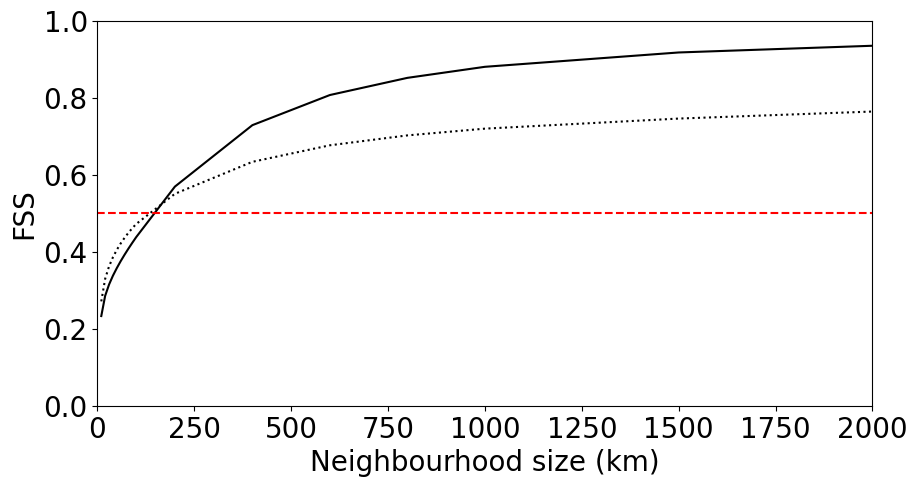

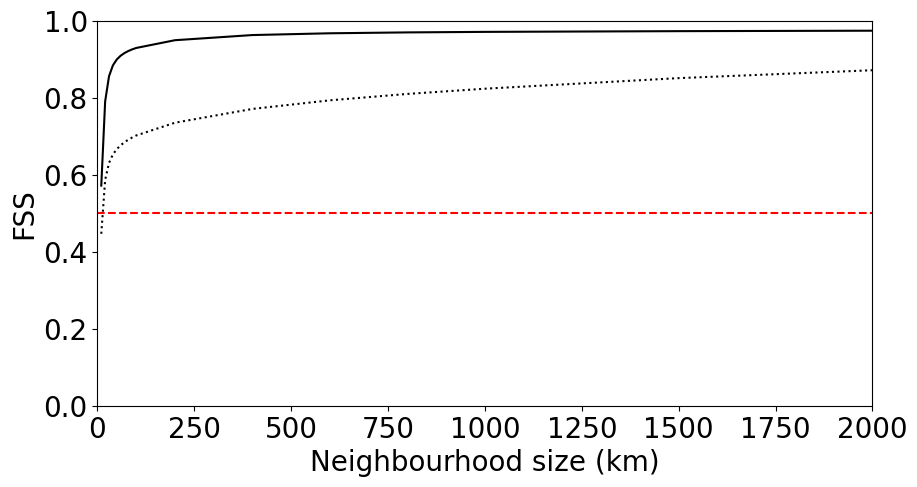

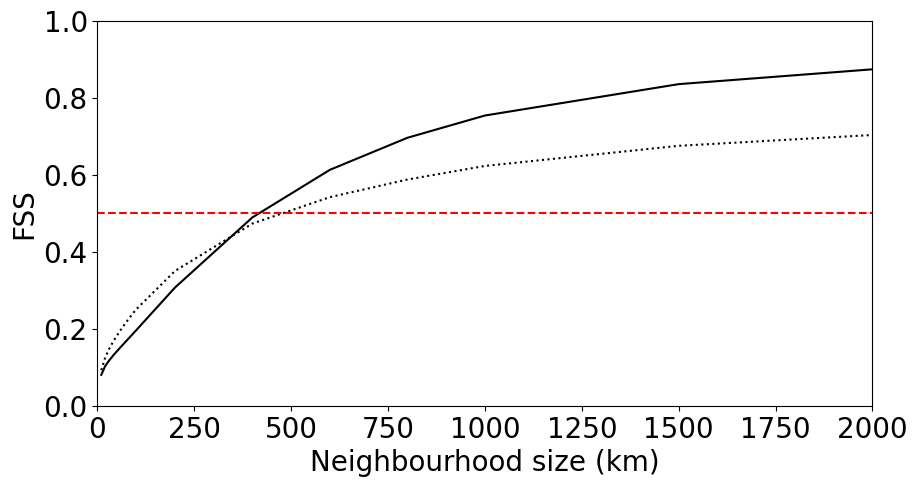

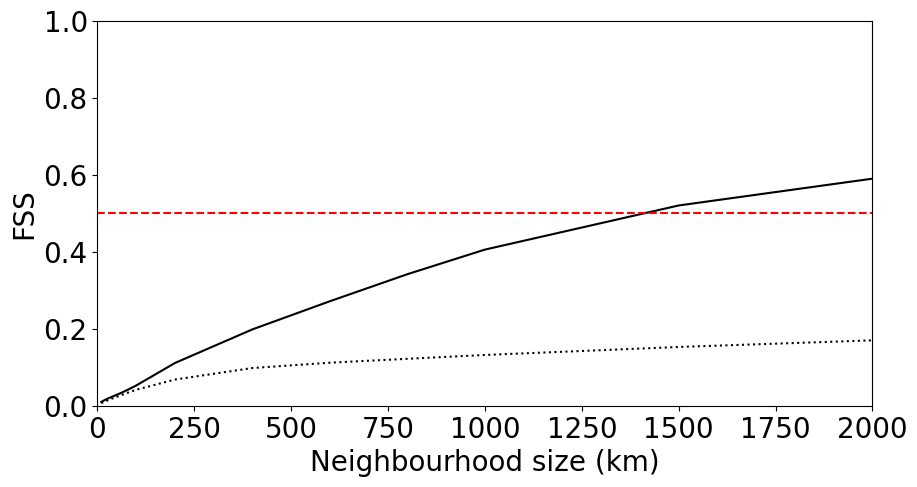

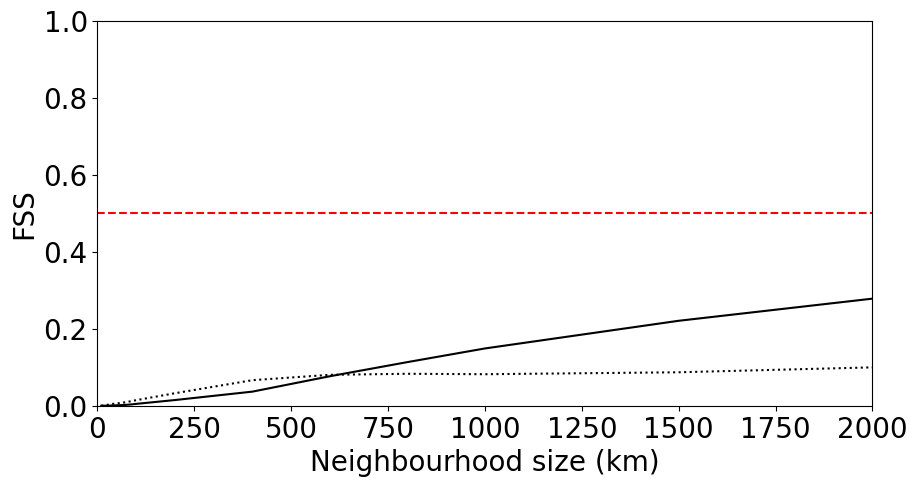

In [76]:
from dsrnngan.plots import plot_fss_scores

linestyles = ['solid', 'dotted', 'dashed', 'dashdot', (0, (1,10))]

axs = []
for n, thr in enumerate(fss_results['thresholds']):

    fig, ax = plt.subplots(1, 1, figsize = (10, 5))

    for m, (name, scores) in enumerate(fss_results['scores'].items()):
        if name == 'Fcst + qmap':
            continue
        else:
            ax.plot([10*item for item in fss_results['window_sizes']], scores[n], label=name, color='k', linestyle=linestyles[m])
        

    # ax.set_title(f'threshold = {thr:0.2f}')
    axs.append(ax)

for ax in axs:

    ax.hlines(0.5, 0, 10*max(fss_results['window_sizes']), linestyles='dashed', colors=['r'])
    ax.set_ylim(0,1)
    ax.set_xlabel('Neighbourhood size (km)')
    ax.set_ylabel('FSS')
    ax.set_xlim(0, 10*max(fss_results['window_sizes']))
    
    # convert to km

    # ax.legend()

In [ ]:
# FSS for regions
window_sizes = list(range(1,11)) + [20, 40, 60, 80, 100] + [150, 200]
n_samples = 10


# get quantiles
quantile_locs = [0.5, 0.985, 0.999, 0.9999]
fss_area_results = {}
for n, (area, area_range) in enumerate(special_areas.items()):
    
    lat_range_ends = area_range['lat_range']
    lon_range_ends = area_range['lon_range']
    lat_range_index = area_range['lat_index_range']
    lon_range_index = area_range['lon_index_range']
    lat_range = np.arange(lat_range_ends[0], lat_range_ends[-1]+0.0001, 0.1)
    lon_range = np.arange(lon_range_ends[0], lon_range_ends[-1]+0.0001, 0.1)
    
    area_truth_array = truth_array[:,lat_range_index[0]:lat_range_index[1], lon_range_index[0]:lon_range_index[1]]
    fss_data_dict = {
                    'cgan': samples_gen_array[:n_samples, lat_range_index[0]:lat_range_index[1], lon_range_index[0]:lon_range_index[1], 0],
                    'ifs': fcst_array[:n_samples,lat_range_index[0]:lat_range_index[1], lon_range_index[0]:lon_range_index[1]],
                    'fcst_qmap': fcst_corrected[:n_samples, lat_range_index[0]:lat_range_index[1], lon_range_index[0]:lon_range_index[1]]}  
    fss_area_results[area] = get_fss_scores(area_truth_array, fss_data_dict, quantile_locs, window_sizes, n_samples)
    
    plot_fss_scores(fss_results=fss_area_results[area], output_folder='plots', output_suffix=f'{area}_{model_type}_{model_number}')
    

## Diurnal cycle

In [ ]:
from dsrnngan.evaluation import get_diurnal_cycle


In [ ]:
hourly_data_obs, hourly_data_sample, hourly_data_fcst, hourly_data_fcst_persisted, hourly_counts = get_diurnal_cycle(truth_array, 
                                                                                                                     samples_gen_array, 
                                                                                                                     fcst_array, 
                                                                                                                     persisted_fcst_array, 
                                                                                                                     dates, hours, longitude_range, latitude_range)

In [ ]:
# Plot diurnal cycle

fig, ax = plt.subplots(1,1, figsize=(10,10))
diurnal_data_dict = {'IMERG': hourly_data_obs,
                     'cGAN sample': hourly_data_sample,
                     'IFS': hourly_data_fcst,
                     'Persisted': hourly_data_fcst_persisted}

for name, data in diurnal_data_dict.items():
    
    mean_hourly_data = [(data[n]/hourly_counts[n]) for n in range(24)]
    # std_dev_hourly_data = np.array([data[n].std() for n in range(24)])
    
    # ax.errorbar(x=range(24), y=mean_hourly_data, fmt='-o', yerr=2*std_dev_hourly_data, label=name)
    ax.plot(mean_hourly_data, '-o', label=name)
    
ax.legend()
ax.set_xlabel('Hour')
ax.set_ylabel('Average mm/hr')
plt.savefig(f'cgan_metrics/diurnal_cycle_{model_type}_{model_number}.pdf')

In [ ]:
# Diurnal cycles for different areas
hourly_area_data_obs, hourly_area_data_sample, hourly_area_data_fcst, hourly_area_counts = {}, {}, {}, {}

for n, (area, area_range) in enumerate(special_areas.items()):
    
    lat_range_ends = area_range['lat_range']
    lon_range_ends = area_range['lon_range']
    lat_range_index = area_range['lat_index_range']
    lon_range_index = area_range['lon_index_range']
    lat_range = np.arange(lat_range_ends[0], lat_range_ends[-1]+0.0001, 0.1)
    lon_range = np.arange(lon_range_ends[0], lon_range_ends[-1]+0.0001, 0.1)
    
    hourly_area_data_obs[area], hourly_area_data_sample[area], hourly_area_data_fcst[area], hourly_area_counts[area] = get_diurnal_cycle( truth_array[:, lat_range_index[0]:lat_range_index[1], lon_range_index[0]:lon_range_index[1]], 
                                                                                             samples_gen_array[:, lat_range_index[0]:lat_range_index[1], lon_range_index[0]:lon_range_index[1], :], 
                                                                                             fcst_array[:, lat_range_index[0]:lat_range_index[1], lon_range_index[0]:lon_range_index[1]], dates, hours, 
                                                                                             longitude_range=lon_range, latitude_range=lat_range)

# Plot diurnal cycle for the different areas

fig, ax = plt.subplots(len(special_areas),1, figsize=(12,18))
fig.tight_layout(pad=3)
diurnal_data_dict = {'IMERG': hourly_area_data_obs,
                    'cGAN sample': hourly_area_data_sample,
                    'IFS': hourly_area_data_fcst}
# TODO: get errorbars on this
for n, area in enumerate(special_areas):
    for name, data in diurnal_data_dict.items():
        mean_hourly_data = [np.mean(data[area][n] / hourly_area_counts[area][n]) for n in range(23)]
        
        ax[n].plot(mean_hourly_data, '-o', label=name)
    
    ax[n].legend()
    ax[n].set_xlabel('Hour')
    ax[n].set_ylabel('Average mm/hr')
    ax[n].set_title(area)

In [ ]:
# Diurnal cycle for different seasons

from collections import Counter

seasons_dict = {'MAM': [3,4,5], 'OND': [10,11,12]}
hourly_season_data_obs, hourly_season_data_sample, hourly_season_data_fcst, hourly_season_counts = {}, {}, {}, {}

for n, (season, month_range) in enumerate(seasons_dict.items()):
    hourly_season_data_obs[season], hourly_season_data_sample[season], hourly_season_data_fcst[season], hourly_season_counts[season] = get_diurnal_cycle( truth_array, 
                                                                                             samples_gen_array, 
                                                                                             fcst_array, dates, hours, 
                                                                                             longitude_range=lon_range, latitude_range=lat_range)

# Plot diurnal cycle for the different areas

fig, ax = plt.subplots(len(seasons_dict),1, figsize=(12,12))
fig.tight_layout(pad=3)
diurnal_data_dict = {'IMERG': hourly_season_data_obs,
                     'cGAN sample': hourly_season_data_sample,
                     'IFS': hourly_season_data_fcst}

for n, season in enumerate(seasons_dict):
    for name, data in diurnal_data_dict.items():
        
        mean_hourly_data = [np.mean(data[season][n] / hourly_season_counts[season][n]) for n in range(23)]
        
        ax[n].plot(mean_hourly_data, '-o',label=name)
    
    ax[n].legend()
    ax[n].set_xlabel('Hour')
    ax[n].set_ylabel('Average mm/hr')
    ax[n].set_title(season)

# Locations of high quantiles

In [ ]:
quantile_boundaries = [np.round(item, 6) for item in quantile_boundaries]

In [ ]:
truth_quantiles = np.quantile(truth_array, quantile_boundaries)
sample_quantiles = np.quantile(samples_gen_array[:,:,:,0], quantile_boundaries)
fcst_quantiles = np.quantile(fcst_array, quantile_boundaries)
fcst_corrected_quantiles = np.quantile(fcst_corrected, quantile_boundaries)

In [ ]:
fig, axs = plt.subplots(1,1, subplot_kw={'projection': ccrs.PlateCarree()},
                       figsize=(10,10))

threshold = 55
digitized_truth = np.digitize(truth_array, truth_quantiles)
digitized_sample = np.digitize(samples_gen_array[:,:,:,0], sample_quantiles)


im = plot_contourf(axs, np.sum(digitized_sample >= threshold, axis=0) / np.sum(digitized_truth >= threshold, axis=0), title=f'', cmap='Reds', lat_range=latitude_range, 
                   lon_range=longitude_range)
plt.colorbar(im, ax=axs)

# im = plot_contourf(axs[1], , title=f'', cmap='Reds', lat_range=latitude_range, 
#                    lon_range=longitude_range)
# plt.colorbar(im, ax=axs[1])

# Ratio of quantiles

In [ ]:
truth_quantiles = np.quantile(truth_array, quantile_boundaries, axis=0)
sample_quantiles = np.quantile(samples_gen_array[:,:,:,0], quantile_boundaries, axis=0)
fcst_quantiles = np.quantile(fcst_array, quantile_boundaries, axis=0)
fcst_corrected_quantiles = np.quantile(fcst_corrected, quantile_boundaries, axis=0)

In [ ]:
quantile = 0.9999

# quantile_index = quantile_boundaries.index(quantile)
quantile_index = 59

t = truth_quantiles[quantile_index, :,:]
s = sample_quantiles[quantile_index, :, :]

fig, ax = plt.subplots(1,1, subplot_kw={'projection': ccrs.PlateCarree()},
                       figsize=(10,10))

im = plot_contourf(ax, s / t, title=f'', cmap='Reds', lat_range=latitude_range, 
                   lon_range=longitude_range)
plt.colorbar(im, ax=ax)

## Check locations of max values

In [ ]:
max_samples_gen = np.max(np.max(samples_gen_array, axis=-1), axis=0)
max_truth = np.max(truth_array, axis=0)

In [ ]:
fig, ax = plt.subplots(2,1, subplot_kw={'projection': ccrs.PlateCarree()},
                       figsize=(10,10))
threshold = 300
im = plot_contourf(ax[0], (max_samples_gen > threshold), title=f'Sample max rainfall > {threshold}', cmap='Reds', lat_range=DEFAULT_LATITUDE_RANGE, 
                   lon_range=DEFAULT_LONGITUDE_RANGE)
plt.colorbar(im, ax=ax[0])

obs_thresold = 80
im = plot_contourf(ax[1], (max_truth > obs_thresold), title=f'IMERG max rainfall > {obs_thresold}', cmap='Reds', lat_range=DEFAULT_LATITUDE_RANGE, 
                   lon_range=longitude_range)
plt.colorbar(im, ax=ax[1])

## Single pixel time series


In [ ]:

log_folder_consecutive = '/user/work/uz22147/logs/cgan/d9b8e8059631e76f/n1000_201810-201812_e50'

with open(os.path.join(log_folder_consecutive, f'arrays-160000.pkl'), 'rb') as ifh:
    consecutive_arrays = pickle.load(ifh)
    
cons_truth_array = consecutive_arrays['truth']
cons_samples_gen_array = consecutive_arrays['samples_gen']
cons_fcst_array = consecutive_arrays['fcst_array']
cons_ensmean_array = np.mean(consecutive_arrays['samples_gen'], axis=-1)
cons_dates = consecutive_arrays['dates']
cons_hours = consecutive_arrays['hours']


## Check training data for high rainfall

In [ ]:
# Check range of values in training data
from dsrnngan.tfrecords_generator import create_mixed_dataset, DataGenerator

train = DataGenerator('train',
                           batch_size=1,
                           fcst_shape=(200, 200, 20),
                            con_shape=(200, 200, 2),
                            out_shape=(200, 200, 1),
                           downsample=False, 
                           weights=[0.4, 0.3, 0.2, 0.1], 
                           records_folder='/user/work/uz22147/tfrecords/d34d309eb0e00b04', 
                           )



In [ ]:
from tqdm import tqdm
from dsrnngan.data import denormalise

max_rainfall = 0
take_n = 20000

for a in tqdm(train.take(take_n).as_numpy_iterator()):
    ifs_input = a[0]['lo_res_inputs']
    imerg_output = a[1]['output']
    
    if denormalise(imerg_output.max()) > max_rainfall:
        max_rainfall = denormalise(imerg_output.max())

## Quantiles with training time

In [ ]:
from sklearn.linear_model import LinearRegression

model_numbers = sorted([153600,147200,140800,134400,128000,121600,115200,108800])

truth_quantiles = {}
sample_quantiles = {}

for model_number in tqdm(model_numbers, total=len(model_numbers)):
    if model_number == 160000:
        log_folder = '/user/work/uz22147/logs/cgan/38fba564f1c9852b/n1000_201806-201905_e50'
    else:
        log_folder = '/user/work/uz22147/logs/cgan/d9b8e8059631e76f/n1000_201806-201905_e50'

    with open(os.path.join(log_folder, f'arrays-{model_number}.pkl'), 'rb') as ifh:
        arrays = pickle.load(ifh)
        
    truth_array = arrays['truth']
    samples_gen_array = arrays['samples_gen']
    fcst_array = arrays['fcst_array']
    ensmean_array = np.mean(arrays['samples_gen'], axis=-1)
    dates = arrays['dates']
    hours = arrays['hours']

    (n_samples, width, height, ensemble_size) = samples_gen_array.shape

    ## This is needed until code is fixed

    if model_number == 160000:
        for n in range(fcst_array.shape[0]):
            fcst_array[n,:,:] = denormalise(fcst_array[n,:,:])
            
    number_in_top_range = 10000
    quantile_boundaries = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8] + list(np.linspace(0.9, 1.0, number_in_top_range))
    truth_quantiles[model_number] = np.quantile(truth_array, quantile_boundaries)
    sample_quantiles[model_number] = np.quantile(samples_gen_array[:,:,:,0], quantile_boundaries)
    print('Number data points per quantile in top range: ', 0.1*len(truth_array.flatten()) / number_in_top_range)
    print('percentile steps in top range: ', 10 / number_in_top_range)
    
fig, ax = plt.subplots(1,1, figsize=(8,6))

for n, model_number in enumerate(model_numbers):
    
    truth_q = truth_quantiles[model_number]
    sample_q = sample_quantiles[model_number]
    
    ax.plot(truth_q, sample_q, label=model_number)

ax.legend()
plt.savefig('cgan_metrics/quantiles_by_iterations.png')

In [ ]:
!zip -r cgan_metrics.zip cgan_metrics